# 基于LSTM实现对股票价格的预测2.0

本项目是在《基于LSTM实现对股票价格的预测》项目基础上对单维LSTM网络改编为多维LSTM网络的版本，因此背景知识就不再赘述。

如若对背景知识不了解请到《基于LSTM实现对股票价格的预测》项目网址：[https://aistudio.baidu.com/aistudio/projectdetail/4136313?channelType=0&channel=0](http://)查看

项目步骤：
1. 导入引用库
2. 通过调用Tushare的数据接口获取股票历史数据（日线）
3. 数据处理
4. 建立模型
5. 模型训练
6. 模型预测

In [2]:
!pip install tushare

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 31.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## 1.导入引用库

In [3]:
# 导入需要的依赖包
import numpy as np  #主要用于数组和矩阵的处理、数学运算和数值分析
import matplotlib.pyplot as plt #绘图库，主要用于绘制折线图
import paddle  
import paddle.fluid as fluid  #早期版本的核心模块，提供了很多底层 API 用于定义计算图、操作张量、定义神经网络等
import pandas as pd  #用于数据处理和转换 
from paddle.utils.plot import Ploter  #用于生成训练过程中的图表,如损失曲线
import tushare as ts


## 2.通过调用Tushare的数据接口获取股票历史数据（日线）

股票数据来源为Tushare大数据开放社区 [https://tushare.pro/](http://)

In [4]:


# 设置Tushare Token,以便进行股票数据请求
ts.set_token('5489b79a9cf99f44d48b63939e6b661e00b1a5e0795b4009f640cf2b')  
pro = ts.pro_api() #获取 Tushare Pro API 的接口

def get_stock_data(stock_code):
    """
    获取股票历史数据（日线）并转换为 .cxv 格式
    :param stock_code: 股票代码（如000001.SZ）
    :return: DataFrame格式的历史数据
    """
    try:
        # 获取日线数据
        df = pro.daily(ts_code=stock_code)

        # 列名映射
        df_cxv = df.rename(columns={
            'trade_date': 'dateTime',#开盘日期
            'open': 'startPrice', #开盘价
            'close': 'endPrice', #收盘价
            'low': 'minPrice', #最低价
            'high': 'maxPrice', #最高价
            'vol': 'turnoverAmount', #成交量
            'pct_chg': 'diffPercent' #涨跌幅
        })

        # 转换日期格式
        df_cxv['dateTime'] = pd.to_datetime(df_cxv['dateTime'])
        

        # 按时间升序排列（旧在前，新在后）
        df_cxv.sort_values('dateTime', ascending=True, inplace=True)
        df_cxv.reset_index(drop=True, inplace=True)  # 重置索引

        # 添加一列 nextdaymaxPrice，表示下一日最高价列
        df_cxv['nextdaymaxPrice'] = df_cxv['maxPrice'].shift(-1)
        
        # 保留所需列
        columns_to_keep = [
            'dateTime', 'startPrice', 'endPrice', 'minPrice', 
            'maxPrice', 'turnoverAmount', 'amount', 'diffPercent', 'nextdaymaxPrice'
        ]
        df_cxv = df_cxv[columns_to_keep]
        

        return df_cxv

    except Exception as e:
        print(f"数据转换失败: {e}")
        return None


# 获取股票代码为000001.SZ（平安银行）的历史数据
stock_code = input("输入所选股票代码（格式：代码.SZ/SH）：").strip()
stock_data = get_stock_data(stock_code)

if stock_data is not None:
    # 如果成功获取到数据，保存为 .csv 文件
    stock_data.to_csv("./data/historicaldata.csv", index=False)
    print("数据已保存到 historicaldata.csv")
    
else:
    print("未能获取到有效数据，请检查股票代码或网络连接。")

输入所选股票代码（格式：代码.SZ/SH）：数据已保存到 historicaldata.csv


## 3.数据处理
![](https://ai-studio-static-online.cdn.bcebos.com/4e4cb490737f49aaa30ef856576838d549f016d9100f49bcb21def8db67584aa)

上图为在举例股票在.cxv文件中的历史数据存储的格式 我们要经过预处理，在其中提取所需数据并设置为我们希望的格式，并将其划分训练数据与测试数据

In [18]:
#定义归一化函数
def normalization(data):
    result_data = (data - avg) / (max_ - min_) #最小-最大归一化方法，将数据缩放到一个特定的范围[-1,1]
    return result_data



In [19]:
#获取数据
dataset =pd.read_csv('./data/historicaldata.csv',index_col='dateTime',parse_dates=['dateTime'])
Num_row = dataset.shape[0]-1  
data = dataset[1:Num_row] #去掉包含空数据的第一行与最后一行数据
data_set0 = np.array(data, dtype='float32') #转换为数据类型为32位浮点数的 NumPy 数组
avg = np.mean(data_set0, axis=0) #axis=0 表示按列进行操作
max_ = np.max(data_set0, axis=0)
min_ = np.min(data_set0, axis=0)

data_set0 = normalization(data_set0)

[[ 0.09901572  0.08991792  0.09594762 ... -0.07913107 -0.06494497
   0.10567019]
 [ 0.09116232  0.10668163  0.08998956 ... -0.07357608  0.19585979
   0.12212736]
 [ 0.11448454  0.12437662  0.11739661 ... -0.04768546  0.19884042
   0.13835591]
 ...
 [-0.05495858 -0.05885971 -0.05514867 ...  0.06007032 -0.0736782
  -0.06027265]
 [-0.05924226 -0.05816123 -0.05467202 ... -0.00620602  0.01042015
  -0.06118694]
 [-0.05852832 -0.0579284  -0.055387   ...  0.00603995  0.00189556
  -0.05798693]]


In [20]:
#划分训练数据与测试数据
DATA_NUM = len(data_set0)
train_len = int(DATA_NUM * 0.8)
train_data = data_set0[:train_len]
test_data = data_set0[train_len: ]
print(train_data.shape)
print(test_data.shape)


(4798, 8)
(1200, 8)


In [21]:
#构造数据读取器reader，批量读取训练数据和测试数据
def my_train_reader():
    def reader(): #逐个返回训练数据的特征和标签
        for temp in train_data:
            yield temp[:-1], temp[-1] #yield 会返回一个（特征，标签）的元组
    return reader

def my_test_reader():
    def reader():
        for temp in test_data:
            yield temp[:-1], temp[-1]    
    return reader


## 4.搭建模型

# 下面的代码实现了一个用于回归任务的 LSTM 网络，主要过程如下：
1. 输入数据通过全连接层 fc0 进行维度扩展。
2. 经过 LSTM 层计算时间序列的隐状态。
3. 对 LSTM 输出进行最大池化，提取重要特征。
4. 使用 tanh 激活函数进行非线性变换。
5. 最后通过全连接层 prediction 进行预测，输出一个标量。
6. 使用平方误差代价函数计算模型的损失，并通过 mean 求得整个批次的平均损失。
这个模型的目标是通过输入的时间序列数据来进行回归预测，常见于时间序列预测等任务

In [22]:
# 定义batch  
#使用 paddle.batch() 将 my_train_reader() 返回的训练数据进行批处理，批大小为 200。这个数据读取器会在训练时按批次返回数据
train_reader = paddle.batch(
    my_train_reader(),
    batch_size=200)  #每次训练时输入到模型的数据量


In [23]:
#搭建LSTM网络
DIM = 1       #输入数据的维度
hid_dim2 = 1  #输出的隐藏层维度

#lod_level=0表示0 means the input data is not a sequence

#x：输入数据，数据类型为 float32，形状为 [DIM]（即每个输入样本的维度为 1）
# lod_level=1 表示这是一个序列数据（lod_level 用来表示数据的层次结构，1表示数据是有时间步的序列）
# label：标签数据，形状为 [1]，用于回归任务的目标值。

x = fluid.layers.data(name='x', shape=[DIM], dtype='float32', lod_level=1)  
label = fluid.layers.data(name='y', shape=[1], dtype='float32')
# Lstm layer
fc0 = fluid.layers.fc(input=x, size=DIM * 4)
lstm_h, c = fluid.layers.dynamic_lstm(
    input=fc0, size=DIM * 4, is_reverse=False)
# 输入为经过全连接层处理后的数据，LSTM 单元输出有 4 个特征，LSTM 网络是正向的，即按时间步顺序处理数据

# 对LSTM 隐藏层状态进行最大池化，选择序列中的最大值，从每个时间步的输出中提取出最显著的特征
lstm_max = fluid.layers.sequence_pool(input=lstm_h, pool_type='max')
# 激活函数
# 对池化后的结果应用 tanh 激活函数，这将把数据的范围压缩到 [-1, 1] 之间
lstm_max_tanh = fluid.layers.tanh(lstm_max)
# 全连接层，使用一个全连接层，将经过 tanh 激活后的池化数据输入，并输出维度为1
prediction = fluid.layers.fc(input=lstm_max_tanh, size=hid_dim2, act='tanh')
# 代价函数，计算预测值和真实标签之间的平方误差
cost = fluid.layers.square_error_cost(input=prediction, label=label)
# 平均代价，最终的损失函数，表示整个批次数据的平均误差，在模型训练时会最小化该损失
avg_cost = fluid.layers.mean(x=cost)


## 5.训练模型

In [24]:
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title) #创建了Ploter类的实例

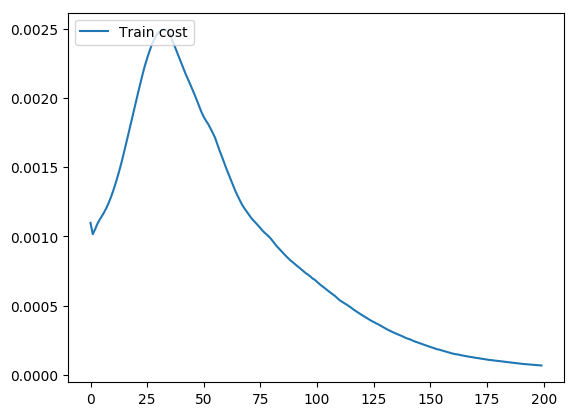

Epoch 199, total avg cost = 0.000041


<Figure size 640x480 with 0 Axes>

In [25]:
# 定义优化器
# 使用百度飞桨框架中的Adam优化器来优化模型参数
# Adam优化器是基于梯度的一种自适应学习率方法，通常能在训练过程中快速收敛
adam_optimizer = fluid.optimizer.Adam(learning_rate=0.001)
adam_optimizer.minimize(avg_cost) #指定优化器最小化的平均损失函数

# 使用CPU
place = fluid.CPUPlace()
# place = fluid.CUDAPlace(1)

exe = fluid.Executor(place) #创建执行器。
exe.run( fluid.default_startup_program() ) #初始化全局启动程序，初始化网络中的参数

feeder = fluid.DataFeeder(place=place, feed_list=[x, label]) #数据馈送器，将数据喂入模型
# 定义双层循环
def train_loop():
    step = 0 
    Epoch = 200
    for epoch_id in range(Epoch):
        total_loss_pass = 0 #每一轮开始时，将总损失初始化为0
        for data in train_reader(): #从训练数据集中按照批次读取数据          
            avg_loss_value,  = exe.run(  #当前批次的平均损失
                fluid.default_main_program(), #返回默认的主计算图
                feed= feeder.feed(data),  #将当前批次的数据传递给计算图
                fetch_list=[avg_cost]) #从计算图中获取模型的损失数据
            total_loss_pass += avg_loss_value  
        # 画图
        plot_cost.append(train_title, step, avg_loss_value)
        step += 1
        plot_cost.plot()
    fluid.io.save_inference_model(SAVE_DIRNAME, ['x'], [prediction], exe) 
    #将训练后的模型保存到指定的目录，['x']是输入变量，[prediction]是预测结果，exe用于执行保存操作
    print("Epoch %d, total avg cost = %f" % (epoch_id, total_loss_pass/Epoch))
SAVE_DIRNAME = 'model'
train_loop()

## 6.模型预测


In [26]:
#测试数据处理，将传入的temp_arr转化为LoDTensor（层次化的张量）
def convert2LODTensor(temp_arr, len_list):
    temp_arr = np.array(temp_arr) #将传入的temp_arr转换为NumPy数组
    temp_arr = temp_arr.flatten().reshape((-1, 1)) #把测试样本的array平坦化到一维数据的格式
    return fluid.create_lod_tensor(
        data=temp_arr, #对测试样本来说这里表示样本的平坦化数据列表
        recursive_seq_lens =[len_list], #对于测试样本来说这里全是6，所以为列表
        place=fluid.CPUPlace()
        )#返回：A fluid LoDTensor object with tensor data and recursive_seq_lens info
    
def get_tensor_label(mini_batch):  
    tensor = None 
    labels = [] #初始化一个空列表用于存储标签
    
    temp_arr = [] #初始化一个空列表用于存储输入数据（即特征x）
    len_list = [] #用于存储每个样本的序列长度
    for _ in mini_batch:   #mini_batch表示的测试样本数据
        labels.append(_[1]) #收集 label----y
        temp_arr.append(_[0]) #收集序列本身--x
        len_list.append(len(_[0])) #收集每个序列x的长度,和上边x的维度对应
    tensor = convert2LODTensor(temp_arr, len_list)    
    return tensor, labels

my_tensor = None
labels = None

size = test_data.shape[0]
# 定义batch
test_reader = paddle.batch(
    my_test_reader(),
    batch_size=size)#一次性把样本取完


for mini_batch in test_reader():
    my_tensor,labels = get_tensor_label(mini_batch)#其实就是变成tensor格式的x和y
    break

In [27]:
#模型预测
place = fluid.CPUPlace()
exe = fluid.Executor(place)
inference_scope = fluid.core.Scope() #创建一个 Scope 对象，表示一个命名空间，用来存储计算图和相关变量。
with fluid.scope_guard(inference_scope):#模型的变量和计算会被限制在这个作用域中，不会污染全局作用域。
    [inference_program, feed_target_names, fetch_targets] = (
        fluid.io.load_inference_model(SAVE_DIRNAME, exe)) #加载一个已经保存的推理模型，包括模型的计算图、输入和输出的目标名称。
    results = exe.run(inference_program, #运行模型进行推理
                      feed= {'x': my_tensor}, #{feed_target_names[0]:my_tensor },和上面保存模型时统一
                      fetch_list=fetch_targets) #要获取的输出目标，即模型的预测结果。


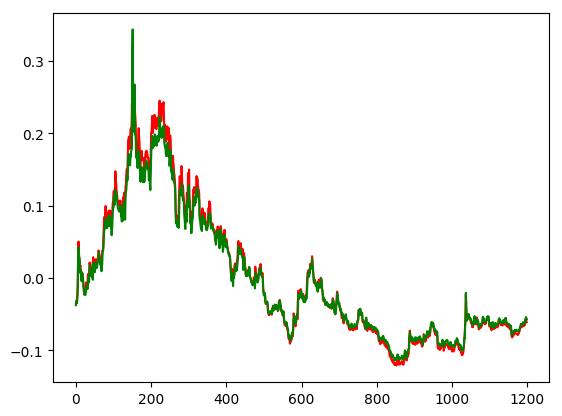

In [28]:
#预测结果
result_print = results[0].flatten()
x1=[]
for x in test_data:
    x1.append(x[3])
plt.figure()
plt.plot(list(range(len(x1))), x1, color='r', label='真实值')  #红线为真实值
plt.plot(list(range(len(result_print))), result_print, color='g', label='预测值')  #绿线为预测值
plt.show()